In [1]:
library(tidyverse)
true_hist <- read_csv("true_history.csv")

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Rows: 1819 Columns: 5
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
dbl (5): days, susceptible, infected, recovered, total

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [2]:
head(true_hist)

days,susceptible,infected,recovered,total
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
36,682,0,0,682
37,682,0,0,682
38,682,0,0,682
39,682,0,0,682
40,682,0,0,682
41,682,0,0,682


Now mcstate

In [4]:
df <- true_hist[,c("days", "infected")]

In [5]:
dt <- 1
sir_data <- mcstate::particle_filter_data(data = df,
                                          time = "days",
                                          rate = 1 / dt)
head(rmarkdown::paged_table(sir_data))

,days_start,days_end,step_start,step_end,infected
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35,36,35,36,0
2,36,37,36,37,0
3,37,38,37,38,0
4,38,39,38,39,0
5,39,40,39,40,0
6,40,41,40,41,0


In [6]:
case_compare <- function(state, observed, pars = NULL) {
  exp_noise <- 1e6

  incidence_modelled <- state[4 , drop = TRUE]
  incidence_observed <- observed$infected
  lambda <- incidence_modelled +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = incidence_observed, lambda = lambda, log = TRUE)
}

In [7]:
incidence_compare <- function(state, prev_state, observed, pars = NULL) {
  exp_noise <- 1e6

  lambda <- state[4, , drop = TRUE] +
    rexp(n = length(incidence_modelled), rate = exp_noise)
  dpois(x = observed$infected, lambda = lambda, log = TRUE)
}

In [8]:
getwd()

[1] "C:/Users/julia"

In [17]:
library(odin.dust)
gen_msir <- odin.dust::odin_dust("msir.R")
msir_model <- gen_sir$new(pars = list(), step = 0, n_particles = 3L)

Using cached model



In [19]:
n_particles <- 1
filter <- mcstate::particle_filter$new(data = sir_data,
                                       model = gen_msir,
                                       n_particles = n_particles,
                                       compare = case_compare,
                                       seed = 3L)

In [20]:
filter$run(save_history = TRUE, pars = list(dt = dt))

[1] -4989.839

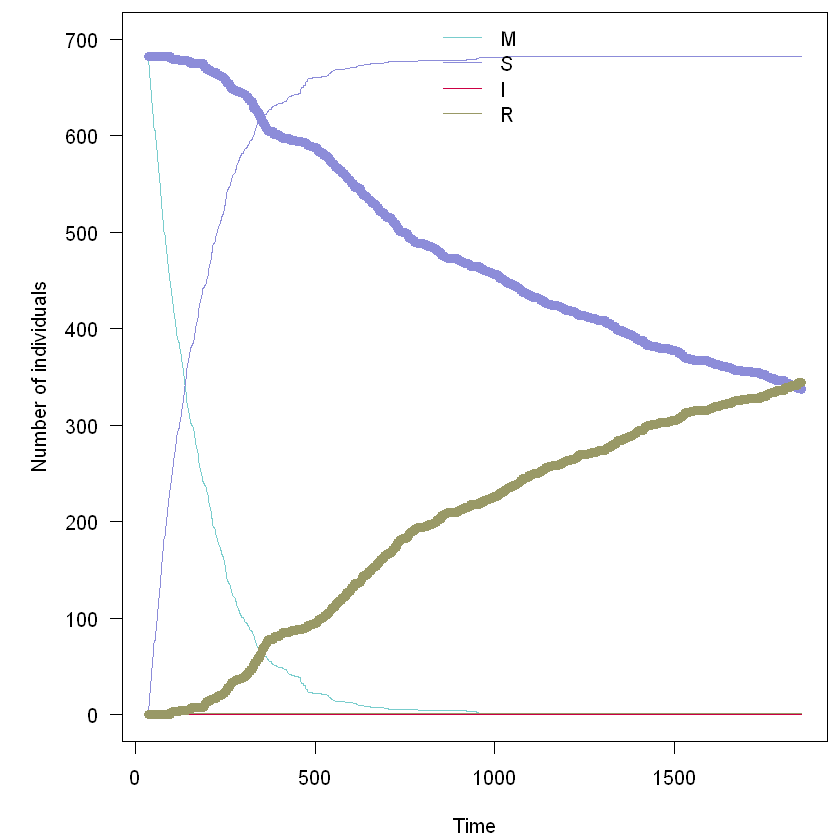

In [27]:
plot_particle_filter <- function(history, true_history, times, obs_end = NULL) {
  if (is.null(obs_end)) {
    obs_end <- max(times)
  }

  par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
  cols <- c(M = "#79CDCD", S = "#8c8cd9", I = "#cc0044", R = "#999966")
  matplot(times, (history[2, , -1]), type = "l",
          xlab = "Time", ylab = "Number of individuals",
          col = cols[["M"]], lty = 1, ylim = c(0, 700))
  matlines(times, (history[3, , -1]), col = cols[["S"]], lty = 1)
  matlines(times, (history[4, , -1]), col = cols[["I"]], lty = 1)
  matlines(times, (history[5, , -1]), col = cols[["R"]], lty = 1)
  matpoints(t(times), t(true_history[,2, -1]), pch = 19,col = cols["S"])
  #matpoints(t(times), t(true_history[,3, -1]), pch = 19,col = cols["I"])
  matpoints(t(times), t(true_history[,4, -1]), pch = 19,col = cols["R"])
  legend("top", lwd = 1, col = cols, legend = names(cols), bty = "n")
}

true_history <- true_hist
plot_particle_filter(filter$history(), true_history, df$days)

**Trying to infer parameters**

In [13]:
beta <- mcstate::pmcmc_parameter("beta", 0.2, min = 0)
gamma <- mcstate::pmcmc_parameter("gamma", 0.22, min = 0)
mu <- mcstate::pmcmc_parameter("mu", 0.00748503, min = 0)

proposal_matrix <- diag(0.1, 3)
mcmc_pars <- mcstate::pmcmc_parameters$new(list(beta = beta, gamma = gamma, mu = mu),
                                           proposal_matrix)

In [14]:
n_steps <- 500
n_burnin <- 200
control <- mcstate::pmcmc_control(
    n_steps,
    save_state = TRUE,
    save_trajectories = TRUE,
    progress = TRUE)
pmcmc_run <- mcstate::pmcmc(mcmc_pars, filter, control = control)

Running chain 1 / 1


Step 1 / 500 [-------------------------------------] ETA  3m | 00:00:00 so far

Step 2 / 500 [-------------------------------------] ETA  3m | 00:00:00 so far

Step 3 / 500 [-------------------------------------] ETA  3m | 00:00:01 so far

Step 4 / 500 [-------------------------------------] ETA  3m | 00:00:01 so far

Step 5 / 500 [-------------------------------------] ETA  3m | 00:00:01 so far

Step 6 / 500 [-------------------------------------] ETA  3m | 00:00:02 so far

Step 7 / 500 [>------------------------------------] ETA  3m | 00:00:02 so far

Step 8 / 500 [>------------------------------------] ETA  3m | 00:00:02 so far

Step 9 / 500 [>------------------------------------] ETA  3m | 00:00:03 so far

Step 10 / 500 [>-----------------------------------] ETA  3m | 00:00:03 so far

Step 11 / 500 [>-----------------------------------] ETA  3m | 00:00:03 so far

Step 12 / 500 [>-----------------------------------] ETA  3m | 00:00:04 so far

Step 13 / 500 [>--

In [15]:
processed_chains <- mcstate::pmcmc_thin(pmcmc_run, burnin = n_burnin, thin = 2)
parameter_mean_hpd <- apply(processed_chains$pars, 2, mean)
parameter_mean_hpd

beta     gamma        mu 
0.7921447 0.4802146 1.5066946

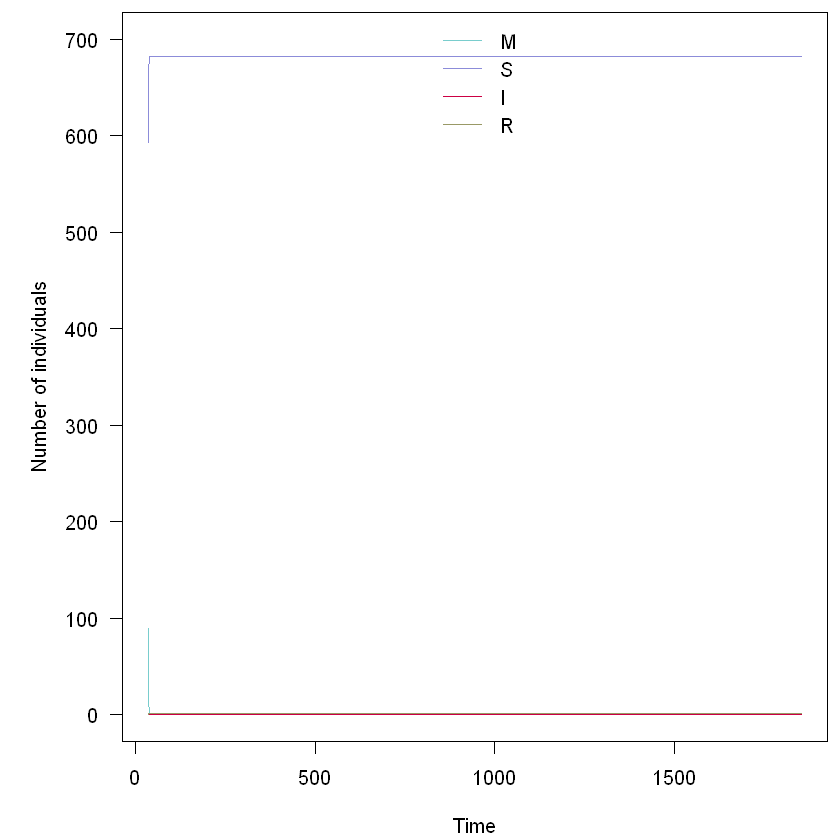

In [16]:
plot_particle_filter <- function(history, true_history, times, obs_end = NULL) {
  if (is.null(obs_end)) {
    obs_end <- max(times)
  }

  par(mar = c(4.1, 5.1, 0.5, 0.5), las = 1)
  cols <- c(M = "#79CDCD", S = "#8c8cd9", I = "#cc0044", R = "#999966")
  matplot(times, (history[2, , -1]), type = "l",
          xlab = "Time", ylab = "Number of individuals",
          col = cols[["M"]], lty = 1, ylim = c(0, 700))
  matlines(times, (history[3, , -1]), col = cols[["S"]], lty = 1)
  matlines(times, (history[4, , -1]), col = cols[["I"]], lty = 1)
  matlines(times, (history[5, , -1]), col = cols[["R"]], lty = 1)
  #matpoints(t(times), t(true_history[,2, -1]), pch = 19,col = cols["S"])
  #matpoints(t(times), t(true_history[,3, -1]), pch = 19,col = cols["I"])
  #matpoints(t(times), t(true_history[,4, -1]), pch = 19,col = cols["R"])
  legend("top", lwd = 1, col = cols, legend = names(cols), bty = "n")
}

true_history <- true_hist
plot_particle_filter(filter$history(), true_history, df$days)